In [1]:
import sys
import time

import json

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tqdm

import japanize_matplotlib

import math
from copy import deepcopy

from numpy.random import RandomState
from numpy.linalg import det, inv
from scipy.special import logsumexp, loggamma
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from mpmath import mp

# Classes and Functions

In [2]:
class FCM():

    def __init__(self, *, K=20, m=2, max_iter=100, random_state=None):
        """
        Args:
            K (int): number of clusters.
            m (float): fuzzy parameter.
            max_iter (int): max number of iterations,
            random_state (Optional[Union[int, np.random.RandomState]): random_state.
        """
        self.K = K
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state

    def init_U(self, X):
        """initialization of U.
        Initialization of the responsibility parameter U.
        Args:
            X (np.ndarray): data.
        Returns:
            U: responsibility matrix.
        """
        N = len(X)

        km = KMeans(n_clusters=self.K, max_iter=10, random_state=self.random_state).fit(X)
        U = np.zeros([N, self.K])
        U[np.arange(N), km.labels_] = 1

        return U

    def create_dist(self, X, means):
        """create distance matrix.
        Args:
            X (np.ndarray): data.
            means (np.ndarray): cluster means.
        Returns:
            dist: distance matrix.
        """
        N = len(X)
        dist = np.zeros([N, self.K])

        for k in range(self.K):
            X_mean = X - means[k]
            dist[:, k] = np.sum(X_mean**2, axis=1) + 1e-100

        return dist

    def objective(self, X, U, means, weight):
        """objective function for FCM.
        Args:
            X (np.ndarray): data.
            U (np.ndarray): responsibility matrix.
            means (np.ndarray): cluster means.
            weight (np.ndarray): weight of each data.
        Returns:
            float: objective function for FCM.
        """
        return np.sum(weight.reshape((-1, 1)) * U**self.m * self.create_dist(X, means))

    def update_log_U(self, X, means, weight):
        """update log U.
        Update log U.
        Args:
            X (np.ndarray): data.
            means (np.ndarray): cluster means.
            weight (np.ndarray): weight of each data.
        Returns:
            np.ndarray: log U.
        """
        dist = weight.reshape((-1, 1)) * self.create_dist(X, means)
        log_U = - 1 / (self.m - 1) * np.log(dist)
        log_U -= logsumexp(log_U, axis=1).reshape((-1, 1))
        return log_U

    def update_means(self, X, U, weight):
        """update means.
        Update means.
        Args:
            X (np.ndarray): data.
            U (np.ndarray): responsibility matrix.
            weight (np.ndarray): weight of each data.
        Returns:
            means (np.ndarray): cluster means.
        """
        Um = U.T**self.m * weight
        nk = np.sum(Um, axis=1)
        return np.dot(Um, X) / np.reshape(nk, (-1, 1))

    def fit(self, X, weight=[]):
        """fit.
        Fit FCM to data.
        Args:
            X (np.ndarray): data.
            verbose (bool): if True, print objectives.
            weight (np.ndarray): weight of each data.
        Returns:
            None
        """
        weight = np.array(weight)
        N = len(X)
        if len(weight) == 0:
            weight = np.ones(N)

        U = self.init_U(X)
        self.means_ = self.update_means(X, U, weight)

        for _ in range(self.max_iter):
            self.log_U = self.update_log_U(X, self.means_, weight)
            self.means_ = self.update_means(X, np.exp(self.log_U), weight)

In [3]:
def _log_prob(*, X, means, covariances):
    """Create log probabilities.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
    Returns:
        np.ndarray (shape=(N, K)): log probability matrix.
            Prob[n, k] = log N(X[n]; means[k], covariances[k])
    """
    N = len(X)
    K = len(means)

    log_prob = np.zeros([N, K])
    for k in range(K):
        log_prob[:, k] = multivariate_normal.logpdf(X, mean=means[k], cov=covariances[k])

    return log_prob


def posterior_g(*, X, pi, means, covariances):
    """Posterior probabilities for g1, ..., gK.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture weights.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
    Returns:
        np.ndarray, shape=(N, K): posterior probability matrix for g1, ..., gK.
            Prob[n, k] = Pr(Z = k|X[n])
    """
    log_prob = _log_prob(X=X, means=means, covariances=covariances)
    log_pi_prob = np.log(pi + 1e-50) + log_prob
    log_pi_prob_norm = logsumexp(log_pi_prob, axis=1).reshape([-1, 1])
    log_post_prob = log_pi_prob - log_pi_prob_norm
    return np.exp(log_post_prob)


def posterior_h(*, X, pi, means, covariances, partition):
    """Posterior probabilities for h1, ..., hL.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture weights.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
        partition (np.ndarray, shape=(K, L)): partition matrix.
    Returns:
        np.ndarray, shape=(N, L): posterior probability matrix for h1, ..., hL.
            Prob[n, l] = Pr(Z = l|X[n])
    """
    log_prob = _log_prob(X=X, means=means, covariances=covariances)
    N = len(X)
    L = np.shape(partition)[1]

    rho = np.dot(pi, partition)  # shape=(L,)
    phi = np.reshape(pi, [-1, 1]) * partition / rho  # shape=(K, L)

    log_prob_h = np.zeros([N, L])
    for l in range(L):
        log_prob_h[:, l] = logsumexp(log_prob, b=phi[:, l], axis=1)

    log_rho_prob_h = np.log(rho) + log_prob_h
    log_rho_prob_h_norm = logsumexp(log_rho_prob_h, axis=1).reshape([-1, 1])
    log_w = log_rho_prob_h - log_rho_prob_h_norm

    return np.exp(log_w)

In [4]:
def find_change(score, mode, *, threshold=0.01):
    """find change
    
    Args:
        score (np.ndarray): score
        mode (str): 'K' or 'MC'
    Returns:
        list: change points
    """
    change = []
    last_change = -100
    
    for t in range(9, 100):
        window_l = score[t - 9: t - 4]
        window_r = score[t - 4: t + 1]
        if t - last_change >= 5:
            if mode == 'K':
                if np.median(window_l) != np.median(window_r):
                    change.append(t)
                    last_change = t
            if mode == 'MC':
                if abs(np.median(window_l) - np.median(window_r)) > threshold:
                    change.append(t)
                    last_change = t
    
    return change

def calc_auc_w5(score, ts, tf, up_or_down):
    """
    Args:
        score (np.ndarray): score
        ts: Fastest time of detection
        tf: lowest time for change detection + 1
        up_or_down: 'up' or 'down'
    Returns:
        list: auc
    """
    
    change_score = [0]*100
    for t in range(9, 100):
        window_l = score[t - 9: t - 4]
        window_r = score[t - 4: t + 1]
        if up_or_down == 'up':
            change_score[t] = np.median(window_r) - np.median(window_l)
        else:
            change_score[t] = np.median(window_l) - np.median(window_r)
        #if t < ts or t >= tf:
        #    change_score[t] = abs(change_score[t])    
    
    threshold_list = change_score[9: 100]
    threshold_list.sort(reverse=True)
    
    FAR_benefit_list = [[0,0]]
    for threshold in threshold_list:
        num_FA = 0
        for t in range(9, ts):
            if change_score[t] >= threshold:
                num_FA += 1
        for t in range(tf, 100):
            if change_score[t] >= threshold:
                num_FA += 1

        t_detect = tf
        for t in range(ts, tf):
            if change_score[t] >= threshold:
                t_detect = t
                break

        FAR_benefit_list.append([num_FA / (91 - (tf - ts)), max(1 - (t_detect - ts) / 25, 0)])
    
    AUC = 0
    for i in range(1, len(FAR_benefit_list)):
        AUC += (FAR_benefit_list[i-1][1] + FAR_benefit_list[i][1]) * (FAR_benefit_list[i][0] - FAR_benefit_list[i-1][0]) / 2
    
    return AUC

In [5]:
def _pc_multinomial(N, K):
    """parametric complexity for multinomial distributions.
    Args:
        N (int): number of data.
        K (int): number of clusters.
    Returns:
        float: parametric complexity for multinomial distributions.
    """
    PC_list = [0]

    # K = 1
    if K >= 1:
        PC_list.append(1)

    # K = 2
    if K >= 2:
        r1 = np.arange(N + 1)
        r2 = N - r1
        logpc_2 = logsumexp(sum([
            loggamma(N + 1),
            (-1) * loggamma(r1 + 1),
            (-1) * loggamma(r2 + 1),
            r1 * np.log(r1 / N + 1e-50),
            r2 * np.log(r2 / N + 1e-50)
        ]))
        PC_list.append(np.exp(logpc_2))

    # K >= 3
    for k in range(3, K + 1):
        PC_list.append(PC_list[k - 1] + N * PC_list[k - 2] / (k - 2))

    return PC_list[-1]


def _log_pc_gaussian(N_list, D, R, lmd_min):
    """log parametric complexity for Gaussian distributions.
    Args:
        N_list (np.ndarray): list of the number of data.
        D (int): dimension of data.
        R (float): upper bound of ||mean||^2.
        lmd_min (float): lower bound of the eigenvalues of the covariance matrix.
    Returns:
        np.ndarray: list of the parametric complexity.
    """
    N_list = np.array(N_list)

    log_PC_list = sum([
        D * N_list * np.log(N_list / 2 / math.e) / 2,
        (-1) * D * (D - 1) * np.log(math.pi) / 4,
        (-1) * np.sum(loggamma((N_list.reshape(-1, 1) - np.arange(1, D + 1)) / 2), axis=1),
        (D + 1) * np.log(2 / D),
        (-1) * loggamma(D / 2),
        D * np.log(R) / 2,
        (-1) * D**2 * np.log(lmd_min) / 2
    ])

    return log_PC_list


def log_pc_gmm(K_max, N_max, D, *, R=1e+3, lmd_min=1e-3):
    """log PC of GMM.
    Calculate (log) parametric complexity of Gaussian mixture model.
    Args:
        K_max (int): max number of clusters.
        N_max (int): max number of data.
        D (int): dimension of data.
        R (float): upper bound of ||mean||^2.
        lmd_min (float): lower bound of the eigenvalues of the covariance matrix.
    Returns:
        np.ndarray: array of (log) parametric complexity.
            returns[K, N] = log C(K, N)
    """
    log_PC_array = np.zeros([K_max + 1, N_max + 1])
    r1_min = D + 1

    # N = 0
    log_PC_array[:, 0] = -np.inf

    # K = 0
    log_PC_array[0, :] = -np.inf

    # K = 1
    # N <= r1_min
    log_PC_array[1, :r1_min] = -np.inf
    # N > r1_min
    N_list = np.arange(r1_min, N_max + 1)
    log_PC_array[1, r1_min:] = _log_pc_gaussian(N_list, D=D, R=R, lmd_min=lmd_min)

    # K > 1
    for k in range(2, K_max + 1):
        for n in range(1, N_max + 1):
            r1 = np.arange(n + 1)
            r2 = n - r1
            log_PC_array[k, n] = logsumexp(sum([
                loggamma(n + 1),
                (-1) * loggamma(r1 + 1),
                (-1) * loggamma(r2 + 1),
                r1 * np.log(r1 / n + 1e-100),
                r2 * np.log(r2 / n + 1e-100),
                log_PC_array[1, r1],
                log_PC_array[k - 1, r2]
            ]))

    return log_PC_array

In [6]:
def _loglike(*, X, pi, means, covariances):
    """log-likelihood
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture weights.
        means (np.ndarray, shape=(K, D)): means.
        covarianvces (np.ndarray, shape=(K, D, D)): covariance matrices.
    Returns:
        float: log-likelihood.
    """
    log_prob = _log_prob(X=X, means=means, covariances=covariances)
    log_pi_prob = np.log(pi + 1e-50) + log_prob

    return sum(logsumexp(log_pi_prob, axis=1))


def _comp_loglike(*, X, Z, pi, means, covariances):
    """complete log-likelihood
    Args:
        X (np.ndarray, shape=(N, D)): data.
        Z (np.ndarray, shape=(N,)): latent variables.
        means (np.ndarray, shape=(K, D)): means.
        covarianvces (np.ndarray, shape=(K, D, D)): covariance matrices.
    Returns:
        float: complete log-likelihood.
    """
    _, D = X.shape
    K = len(means)
    nk = np.bincount(Z, minlength=K)

    if min(nk) <= 0:
        return np.nan
    else:
        c_loglike = 0
        for k in range(K):
            c_loglike += nk[k] * np.log(pi[k])
            c_loglike -= 0.5 * nk[k] * D * np.log(2 * math.pi * math.e)
            c_loglike -= 0.5 * nk[k] * np.log(det(covariances[k]))
        return c_loglike


class GMM():
    """Gaussian Mixture Model.
    """

    def __init__(self, *, K, reg_covar=1e-6, random_state=None):
        """
        Args:
            K (int): mixture size.
            reg_covar (float): regularization for covariance matrices.
            random_state (Optional[Union[int, np.random.RandomState]): random_state.
        """
        self.K = K
        self.model = GaussianMixture(
            n_components=K,
            reg_covar=reg_covar,
            random_state=random_state
        )

    def fit(self, X):
        """fit GMM
        Args:
            X (np.ndarray, shape=(N, D)): data
        """
        self.model.fit(X)
    
    def get_params(self):
        """get model parameters
        Returns:
            Dict[str, Any]: gmm_parameters.
        """
        gmm_parameters = {
            'pi': self.model.weights_,
            'means': self.model.means_,
            'covariances': self.model.covariances_
        }
        return gmm_parameters

    def model_score(self, X, *, criterion='NML', log_pc_array=[]):
        """model criterion score
        Args:
            X (np.ndarray, shape=(N, D)): data.
            criterion (str): criterion name.
            log_PC_array (np.ndarray, optional): log PC matrix.
        Returns:
            float: model criterion score.
        """
        # check parameters
        N, D = np.shape(X)
        assert criterion in ['AIC', 'AICcomp', 'BIC', 'BICcomp', 'NML', 'DNML']
        if criterion in ['NML', 'DNML']:
            assert len(log_pc_array) > 0

        # log_like
        gmm_parameters = self.get_params()
        if criterion in ['AIC', 'BIC']:
            log_like = _loglike(X=X, **gmm_parameters)
        elif criterion in ['AICcomp', 'BICcomp', 'NML', 'DNML']:
            Z = self.model.predict(X)
            log_like = _comp_loglike(X=X, Z=Z, **gmm_parameters)

        # complexity
        params = (self.K - 1) + 0.5 * self.K * D * (D + 3)
        if criterion in ['AIC', 'AICcomp']:
            complexity = params
        elif criterion in ['BIC', 'BICcomp']:
            complexity = 0.5 * params * np.log(N)
        elif criterion == 'NML':
            complexity = log_pc_array[self.K, N]
        elif criterion == 'DNML':
            complexity = np.log(_pc_multinomial(N, self.K))
            for k in range(self.K):
                Z_k = sum(Z == k)
                if log_pc_array[1, Z_k] == - np.inf:
                    return np.nan
                else:
                    complexity += log_pc_array[1, Z_k]

        return - log_like + complexity

In [7]:
class SDMS():

    def __init__(
        self, *, K_max=15, criterion='NML',
        log_pc_array=[], beta=0.01, random_state=0, num_em=10,
        reg_covar=1e-3
    ):
        """
        Args:
            K_max (int): max mixture / cluster size.
            criterion (str): criterion name.
            log_PC_array (np.ndarray): log PC matrix.
            beta (float): change rate.
            random_state (Optional[int]): random_state.
            num_em (int): number of EM trials.
            reg_covar (float): regularization for covariance matrices.
        """
        self.K_max = K_max
        self.criterion = criterion
        self.log_pc_array = log_pc_array
        self.beta = beta
        self.num_em = num_em
        self.random_state = random_state
        self.reg_covar = reg_covar

        # random_state
        self.random = RandomState(seed=self.random_state)

        # for next
        self.K_next = np.arange(1, K_max + 1).tolist()
        self.penalty_next = (-np.log(np.ones(K_max) / K_max)).tolist()

    def update(self, X):
        """update
        Args:
            X (np.ndarray): data
        Returns:
            GMM: gmm object
        """

        # create model
        model_list = []
        score_list = []
        for k in range(len(self.K_next)):
            model_list_k = []
            score_list_k = []
            for _ in range(self.num_em):
                model_tmp = GMM(K=self.K_next[k], random_state=self.random, reg_covar=self.reg_covar)
                model_tmp.fit(X)
                model_list_k.append(deepcopy(model_tmp))
                score_list_k.append(
                    model_tmp.model_score(X=X, criterion=self.criterion, log_pc_array=self.log_pc_array)
                    + self.penalty_next[k]
                )
            score_list_k = np.array(score_list_k)
            
            if np.isnan(score_list_k).all():
                continue
            
            idx_best_k = np.nanargmin(score_list_k)
            model_list.append(model_list_k[idx_best_k])
            score_list.append(score_list_k[idx_best_k])

        score_list = np.array(score_list)

        # choose the best model
        idx_best = np.nanargmin(score_list)
        model_best = model_list[idx_best]

        # for next update
        K_now = model_best.K
        if K_now == 1:
            self.K_next = np.array([1, 2])
            self.penalty_next = - np.log([1 - 0.5 * self.beta, 0.5 * self.beta])
        elif K_now == self.K_max:
            self.K_next = np.array([self.K_max - 1, self.K_max])
            self.penalty_next = - np.log([0.5 * self.beta, 1 - 0.5 * self.beta])
        else:
            self.K_next = np.array([K_now - 1, K_now, K_now + 1])
            self.penalty_next = - np.log([0.5 * self.beta, 1 - self.beta, 0.5 * self.beta])

        return model_best, model_list, score_list

In [8]:
def _mc(*, prob_latent, weights):
    """Calculate mixture complexity from prob_latent.
    Args:
        prob_latent (np.ndarray, shape=(N, K)): latent probabilities.
        weights (np.ndarray, shape=(N,)): data weights.
    Returns:
        float: mixture complexity.
    """
    N = len(prob_latent)
    if weights is None:
        weights = np.ones(N)

    rho = np.dot(weights, prob_latent) / np.sum(weights)
    H_Z = - np.dot(rho, np.log(rho + 1e-50))
    H_ZbarX = (
        - np.sum(np.dot(weights, prob_latent * np.log(prob_latent + 1e-50)))
        / np.sum(weights)
    )
    return H_Z - H_ZbarX


def _prob_latent(*, X, pi, means, covariances):
    """Calculate latent probabilities.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture proportions.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
        weights (np.ndarray, shape=(N,)): data weights.
    Returns:
        np.ndarray: latent probabilities (shape = (N, K)).
    """
    log_prob = _log_prob(X=X, means=means, covariances=covariances)
    log_pi_prob = np.log(pi + 1e-50) + log_prob
    log_pi_prob_norm = logsumexp(log_pi_prob, axis=1).reshape([-1, 1])
    return np.exp(log_pi_prob - log_pi_prob_norm)


def mc(*, X, pi, means, covariances, weights=[]):
    """Calculate mixture complexity.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture proportions.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
        weights (np.ndarray, shape=(N,)): data weights.
    Returns:
        float: mixture complexity.
    """
    N = len(X)
    if len(weights) == 0:
        weights = np.ones(N)
    prob_latent = _prob_latent(X=X, pi=pi, means=means, covariances=covariances)

    return _mc(prob_latent=prob_latent, weights=weights)


def _mc_decomp(log_prob, pi, partition):
    """Calculate the decomposition of MC from log_prob.
    Args:
        log_prob (np.ndarray, shape=(N, K)): log probability.
        pi (np.ndarray, shape=(K,)): mixture proportions.
        partition (np.ndarray, shape=(K, L)): partition matrix.
    Returns:
        float, (np.ndarray, shape=(L,)), (np.ndarray, shape=(L,)): MC_interaction, W, MC_local.
    """
    N = len(log_prob)
    L = np.shape(partition)[1]

    rho = np.dot(pi, partition)  # shape=(L,)
    phi = np.reshape(pi, [-1, 1]) * partition / rho  # shape=(K, L)

    log_prob_h = np.zeros([N, L])
    for l in range(L):
        log_prob_h[:, l] = logsumexp(log_prob, b=phi[:, l], axis=1)

    log_rho_prob_h = np.log(rho) + log_prob_h
    log_rho_prob_h_norm = logsumexp(log_rho_prob_h, axis=1).reshape([-1, 1])
    log_w = log_rho_prob_h - log_rho_prob_h_norm
    w = np.exp(log_w)

    MC_interaction = _mc(prob_latent=w, weights=np.ones(N))

    W = np.zeros(L)

    MC_local = np.zeros(L)
    for l in range(L):
        W[l] = sum(w[:, l]) / N
        log_phi_prob = np.log(phi[:, l] + 1e-50) + log_prob
        log_phi_prob_norm = logsumexp(log_phi_prob, axis=1).reshape([-1, 1])

        MC_local[l] = _mc(prob_latent=np.exp(log_phi_prob - log_phi_prob_norm), weights=w[:, l])

    return MC_interaction, W, MC_local


def mc_decomp(*, X, pi, means, covariances, partition):
    """Calculate the decomposition of MC.
    Args:
        X (np.ndarray, shape=(N, D)): data.
        pi (np.ndarray, shape=(K,)): mixture weights.
        means (np.ndarray, shape=(K, D)): mean vectors.
        covariances (np.ndarray, shape=(K, D, D)): covariance matrices.
        weights (np.ndarray, shape=(N,)): data weights.
        partition (np.ndarray, shape=(K, L)): partition matrix.
    Returns:
        float, (np.ndarray, shape=(L,)), (np.ndarray, shape=(L,)): MC_interaction, W, MC_local.
    """
    log_prob = _log_prob(X=X, means=means, covariances=covariances)

    return _mc_decomp(log_prob=log_prob, pi=pi, partition=partition)

In [9]:
class TrackMC():
    """track MC
    Attributes:
        gmm_list_ (List[GMM]): sequence of GMM objects.
    """
    def __init__(
        self, *, K_max=20, criterion='NML',
        beta=0.01, random_state=None, num_em=10, reg_covar=1e-3,
        R=1e+3, lmd_min=1e-3, verbose=True
    ):
        """
        Args:
            K_max (int): max mixture / cluster size.
            criterion (str): criterion name.
            beta (float): change rate.
            random_state (Optional[int]): random_state.
            num_em (int): number of EM trials.
            reg_covar (float): regularization for covariance matrices.
            R (float): upper bound of ||mean||^2.
            lmd_min (float): lower bound of the eigenvalues of the covariance matrix.
            verbose (bool): verbosity.
        """
        self.K_max = K_max
        self.criterion = criterion
        self.beta = beta
        self.random_state = random_state
        self.num_em = num_em
        self.reg_covar = reg_covar
        self.R = R
        self.lmd_min = lmd_min
        self.verbose = verbose

    def fit(self, XX):
        """
        fit to dataset XX.
        Args:
            XX (np.ndarray, shape=(T, N, D)): dataset
        """
        self.gmm_list_ = []
        self.gmm_list_list_ = []
        self.score_list_list_ = []

        # create log_pc_array
        D = XX[0].shape[1]
        N_list = []
        for X in XX:
            N_list.append(len(X))
        N_max = max(N_list)
        log_pc_array = log_pc_gmm(K_max=self.K_max, N_max=N_max, D=D, R=self.R, lmd_min=self.lmd_min)

        # SDMS
        sdms = SDMS(
            K_max=self.K_max, criterion=self.criterion, log_pc_array=log_pc_array, beta=self.beta,
            random_state=self.random_state, num_em=self.num_em, reg_covar=self.reg_covar
        )

        if self.verbose:
            XX_iter = tqdm(XX)
        else:
            XX_iter = XX

        for X in XX_iter:
            model_best, model_list, score_list = sdms.update(X)
            self.gmm_list_.append(model_best)
            self.gmm_list_list_.append(model_list)
            self.score_list_list_.append(score_list)
    
    @property
    def K_list(self):
        """
        get K_list. fit is needed before.
        Returns:
            np.ndarray, shape=(T,): sequence of K.
        """
        K_list = []
        for gmm in self.gmm_list_:
            K_list.append(gmm.K)
        K_list = np.array(K_list)
        return K_list

    def mc_list(self, XX):
        """
        get mc_list. fit is needed before.
        Args:
            XX (np.ndarray, shape=(T, N, D)): dataset
        Returns:
            np.ndarray, shape=(T,): sequence of MC.
        """
        mc_list = []
        for gmm, X in zip(self.gmm_list_, XX):
            gmm_parameters = gmm.get_params()
            mc_list.append(mc(X=X, **gmm_parameters))
        mc_list = np.array(mc_list)
        return mc_list
    
    def mc_fusion_list(self, XX):
        """
        get mc_fusion_list. fit is needed before.
        Args:
            XX (np.ndarray, shape=(T, N, D)): dataset
        Returns:
            np.ndarray, shape=(T,): sequence of MC-fusion.
        """
        mc_fusion_list = []
        for gmm_list, score_list, X in zip(self.gmm_list_list_, self.score_list_list_, XX):
            mc_list_t = []
            for gmm in gmm_list:
                gmm_parameters = gmm.get_params()
                mc_list_t.append(mc(X=X, **gmm_parameters))
            
            score_list_exp = []
            score_best = min(score_list)
            beta = 1 / np.sqrt(len(X))
            for score in score_list:
                score_list_exp.append(np.exp(- beta * (score - score_best)))
            
            mc_t = 0
            for score_exp, mc_k in zip(score_list_exp, mc_list_t):
                mc_t += score_exp * mc_k
            mc_t /= sum(score_list_exp)
            mc_fusion_list.append(mc_t)
        mc_fusion_list = np.array(mc_fusion_list)
        return mc_fusion_list
    
    def ddim_list(self, XX):
        """
        get ddim_list. fit is needed before.
        Args:
            XX (np.ndarray, shape=(T, N, D)): dataset
        Returns:
            np.ndarray, shape=(T,): sequence of Ddim.
        """
        ddim_list = []
        for gmm_list, score_list, X in zip(self.gmm_list_list_, self.score_list_list_, XX):
            score_list_exp = []
            score_best = min(score_list)
            beta = 1 / np.sqrt(len(X))
            for score in score_list:
                score_list_exp.append(np.exp(- beta * (score - score_best)))
            
            ddim_t = 0
            for score_exp, gmm in zip(score_list_exp, gmm_list):
                ddim_t += score_exp * gmm.K
            ddim_t /= sum(score_list_exp)
            ddim_list.append(ddim_t)
        ddim_list = np.array(ddim_list)
        return ddim_list
        
    @property
    def means_list(self):
        """
        get means_list. fit is needed before.
        Returns:
            np.ndarray, shape=(D, -1): sequence of means.
        """
        means_list = []
        for gmm in self.gmm_list_:
            means_list.extend(gmm.model.means_)
        means_list = np.array(means_list)
        return means_list
    
    @property
    def covariances_list(self):
        """
        get covariances_list. fit is needed before.
        Returns:
            np.ndarray, shape=(D, -1): sequence of means.
        """
        covariances_list = []
        for gmm in self.gmm_list_:
            covariances_list.extend(gmm.model.covariances_)
        covariances_list = np.array(covariances_list)
        return covariances_list
    
    @property
    def pi_list(self):
        """
        get pi_list. fit is needed before.
        Returns:
            np.ndarray, shape=(-1,): sequence of pi.
        """
        pi_list = []
        for gmm in self.gmm_list_:
            pi_list.extend(gmm.model.weights_)
        pi_list = np.array(pi_list)
        return pi_list


# Analysis of Artificial Data

## Moving Gaussian dataset

In [10]:
def move_gaussian_dataset(random_state):
    """
    Create move Gaussian dataset.
    
    Args:
        random_state (Optional[int]): random state.
    Returns:
        np.ndarray (shape=(150, 1000, 3)): move Gaussian dataset.
    """
    
    random = np.random.RandomState(seed=random_state)
    
    XX = []
    
    alpha = np.zeros(150)
    alpha[50: 100] = np.arange(50) * 6 / 50
    alpha[100:] = 6
    
    for t in range(150):
        
        X1 = random.randn(333, 3)
        X2 = random.randn(333, 3)
        X3 = random.randn(334, 3)
        
        X2[:, 0] += 10
        X3[:, 0] += 10 + alpha[t]
        
        XX.append(np.r_[X1, X2, X3])
        
    return XX

In [11]:
def plot_move_gaussian_dataset(t):
    """
    plot move gaussian dataset.
    
    Args:
        t (int): time.
        save_name (Optional[str]): file name to save.
    """
    # create data
    XX = move_gaussian_dataset(random_state=0)
    X = XX[t]
    
    # plot setting
    fig, ax = plt.subplots(figsize=(2.5, 1), dpi=200)
    ax.set_xlim(-5.0, 21.0)
    ax.set_ylim(-5.0, 5.0)
    for a in ['top', 'right', 'bottom', 'left']:
        ax.spines[a].set_linewidth(0.5)
    ax.tick_params(labeltop=False, labelright=False,
                   labelbottom=False, labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.98, right=0.98, bottom=0.02, left=0.02)
    
    # scatter X
    ax.scatter(X[:, 0], X[:, 1], color='red', s=1)
    
    #plt.savefig('move_gaissian_t76.pdf')
    
    plt.show()

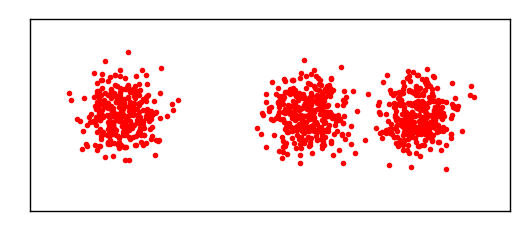

In [12]:
plot_move_gaussian_dataset(t=100)

### forward direction

In [13]:
# data
XX_mgd = move_gaussian_dataset(0)[25:125]

# calculate K, MC, MC-fusion, and Ddim
track_mc_mgd = TrackMC(K_max=10, criterion='NML', reg_covar=1e-3, random_state=0)
track_mc_mgd.fit(XX_mgd)
K_list_mgd = track_mc_mgd.K_list
mc_list_mgd = track_mc_mgd.mc_list(XX_mgd)
mc_fusion_list_mgd = track_mc_mgd.mc_fusion_list(XX_mgd)
ddim_list_mgd = track_mc_mgd.ddim_list(XX_mgd)

# change point
change_K_mgd = find_change(K_list_mgd, 'K')
change_mc_mgd = find_change(mc_list_mgd, 'MC')
change_mc_fusion_mgd = find_change(mc_fusion_list_mgd, 'MC')
change_ddim_mgd = find_change(np.log(ddim_list_mgd), 'MC')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

#### Plotting and Calculation of AUC

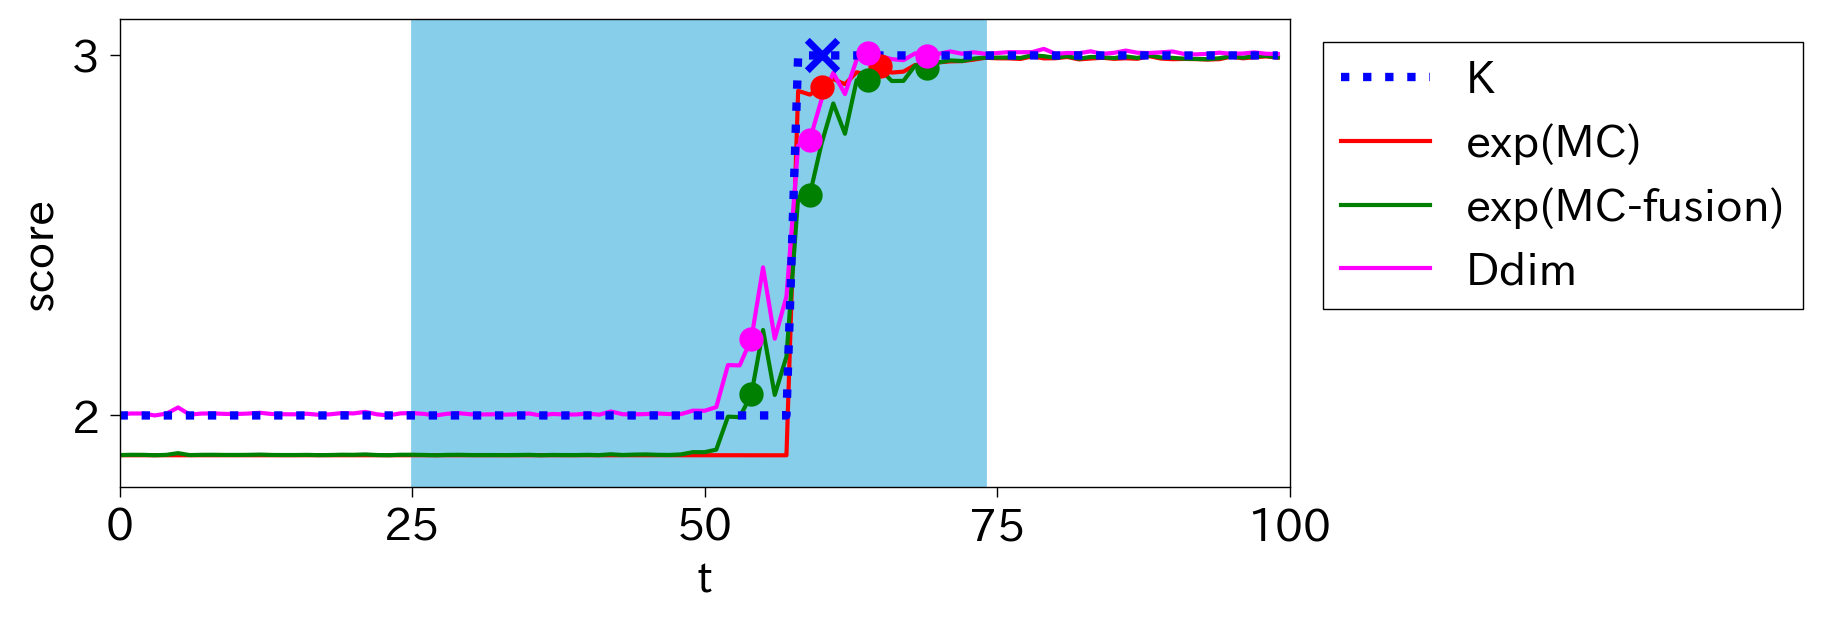

In [14]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 100)
ax.set_ylim(1.8, 3.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks([2, 3])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(25, 75), 1.8, 3.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(100), K_list_mgd, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(100), np.exp(mc_list_mgd), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), np.exp(mc_fusion_list_mgd), color='green', label='exp(MC-fusion)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), ddim_list_mgd, color='magenta', label='Ddim', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K_mgd, np.array(K_list_mgd)[change_K_mgd], color='blue',  s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc_mgd, np.exp(np.array(mc_list_mgd))[change_mc_mgd], color='red',  s=60, marker='o')
ax.scatter(change_mc_fusion_mgd, np.exp(np.array(mc_fusion_list_mgd))[change_mc_fusion_mgd], color='green',  s=60, marker='o')
ax.scatter(change_ddim_mgd, np.array(ddim_list_mgd)[change_ddim_mgd], color='magenta',  s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.01, 1), 
    loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

#plt.savefig('move_gaissian_0to100_1.pdf')
plt.show()

In [15]:
print(calc_auc_w5(mc_fusion_list_mgd, 28, 82, up_or_down = 'up'))
print(calc_auc_w5(mc_list_mgd, 28, 82, up_or_down = 'up'))
print(calc_auc_w5(ddim_list_mgd, 28, 82, up_or_down = 'up'))
print(calc_auc_w5(K_list_mgd, 28, 82, up_or_down = 'up'))

0.7124324324324324
0.5902702702702702
0.6378378378378378
0.5


### reverse direction

In [16]:
# data
XX_mgd_r = move_gaussian_dataset(0)[25:125][::-1]

# calculate K, MC, MC-fusion, and Ddim
track_mc_mgd_r = TrackMC(K_max=10, criterion='NML', reg_covar=1e-3, random_state=0)
track_mc_mgd_r.fit(XX_mgd_r)
K_list_mgd_r = track_mc_mgd_r.K_list
mc_list_mgd_r = track_mc_mgd_r.mc_list(XX_mgd_r)
mc_fusion_list_mgd_r = track_mc_mgd_r.mc_fusion_list(XX_mgd_r)
ddim_list_mgd_r = track_mc_mgd_r.ddim_list(XX_mgd_r)

# change point
change_K_mgd_r = find_change(K_list_mgd_r, 'K')
change_mc_mgd_r = find_change(mc_list_mgd_r, 'MC')
change_mc_fusion_mgd_r = find_change(mc_fusion_list_mgd_r, 'MC')
change_ddim_mgd_r = find_change(np.log(ddim_list_mgd_r), 'MC')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

#### Plotting and Calculation of AUC

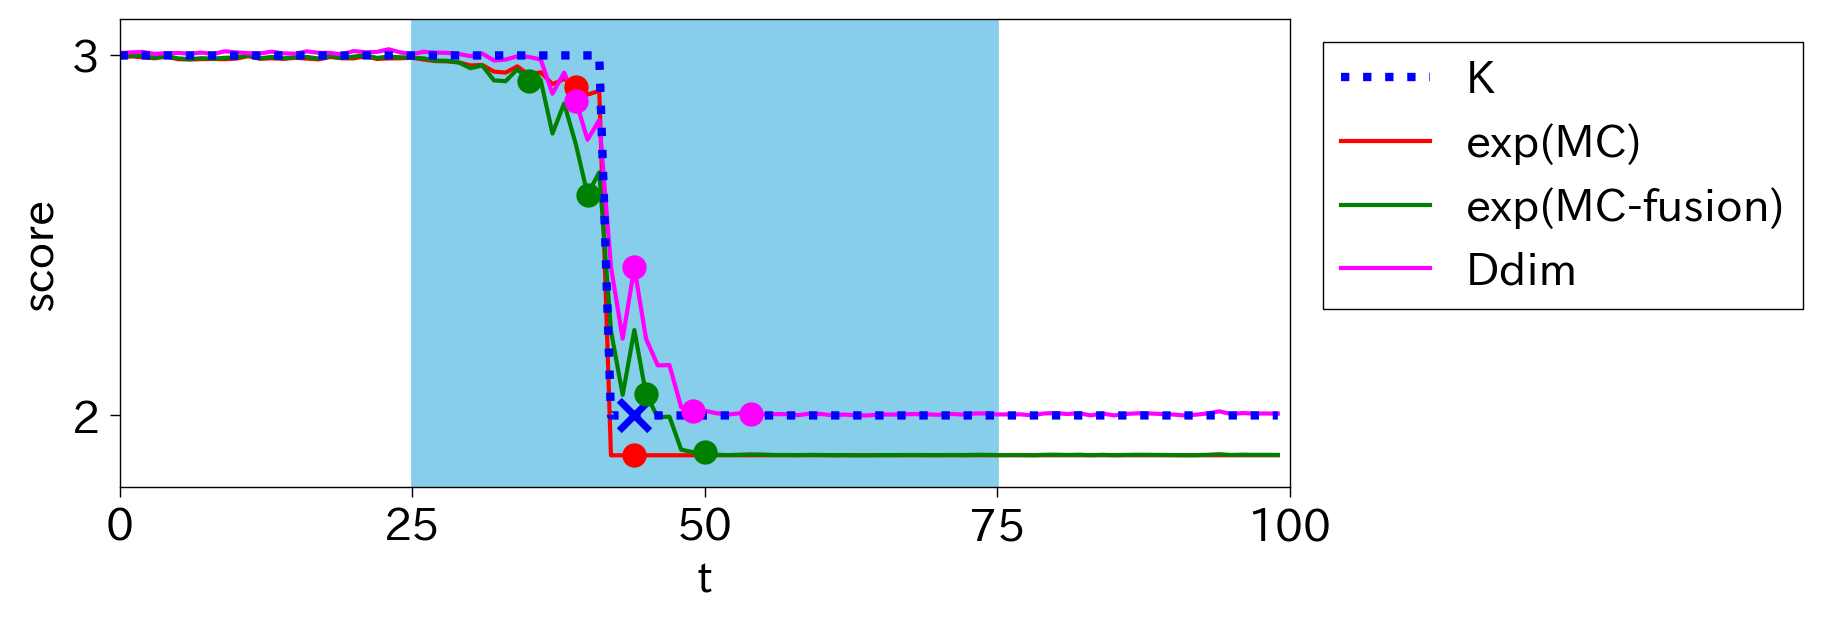

In [17]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 100)
ax.set_ylim(1.8, 3.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks([2, 3])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(25, 76), 1.8, 3.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(100), K_list_mgd_r, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(100), np.exp(mc_list_mgd_r), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), np.exp(mc_fusion_list_mgd_r), color='green', label='exp(MC-fusion)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), ddim_list_mgd_r, color='magenta', label='Ddim', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K_mgd_r, np.array(K_list_mgd_r)[change_K_mgd_r], color='blue',  s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc_mgd_r, np.exp(np.array(mc_list_mgd_r))[change_mc_mgd_r], color='red',  s=60, marker='o')
ax.scatter(change_mc_fusion_mgd_r, np.exp(np.array(mc_fusion_list_mgd_r))[change_mc_fusion_mgd_r], color='green',  s=60, marker='o')
ax.scatter(change_ddim_mgd_r, np.array(ddim_list_mgd_r)[change_ddim_mgd_r], color='magenta', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.01, 1), 
    loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

#plt.savefig('move_gaissian_100to0_1.pdf')
plt.show()

In [18]:
print(calc_auc_w5(mc_fusion_list_mgd_r, 27, 81, up_or_down = 'down'))
print(calc_auc_w5(mc_list_mgd_r, 27, 81, up_or_down = 'down'))
print(calc_auc_w5(ddim_list_mgd_r, 27, 81, up_or_down = 'down'))
print(calc_auc_w5(K_list_mgd_r, 27, 81, up_or_down = 'down'))

0.9951351351351352
0.994054054054054
0.9848648648648649
0.6599999999999999


## Imbalance Gaussian dataset

In [19]:
def imbalance_gaussian_dataset(random_state):
    """
    Create move Gaussian dataset.
    
    Args:
        random_state (Optional[int]): random state.
    Returns:
        np.ndarray (shape=(150, 1000, 3)): move Gaussian dataset.
    """
    random = np.random.RandomState(seed=random_state)
    
    XX = []
    
    alpha = np.zeros(150, dtype=int)
    alpha[50: 100] = np.arange(50) * 5
    alpha[100:] = 250
    
    for t in range(150):
        
        X1 = random.randn(250, 3)
        X2 = random.randn(250, 3)
        X3 = random.randn(250 + alpha[t], 3)
        X4 = random.randn(250 - alpha[t], 3)
        
        X2[:, 0] += 10
        X3[:, 0] += 20
        X4[:, 0] += 30
        
        XX.append(np.r_[X1, X2, X3, X4])
        
    return XX

In [20]:
def plot_imbalance_gaussian_dataset(t):
    """
    plot imbalance gaussian dataset.
    
    Args:
        t (int): time.
        save_name (Optional[str]): file name to save.
    """
    # create data
    XX = imbalance_gaussian_dataset(random_state=0)
    X = XX[t]
    
    # plot setting
    fig, ax = plt.subplots(figsize=(2.5, 1), dpi=200)
    ax.set_xlim(-5.0, 35.0)
    ax.set_ylim(-5.0, 5.0)
    for a in ['top', 'right', 'bottom', 'left']:
        ax.spines[a].set_linewidth(0.5)
    ax.tick_params(labeltop=False, labelright=False,
                   labelbottom=False, labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.98, right=0.98, bottom=0.02, left=0.02)
    
    # scatter X
    ax.scatter(X[:, 0], X[:, 1], color='red', s=1)
    
    #plt.savefig('imbalance_gaissian_t76.pdf')
    
    plt.show()

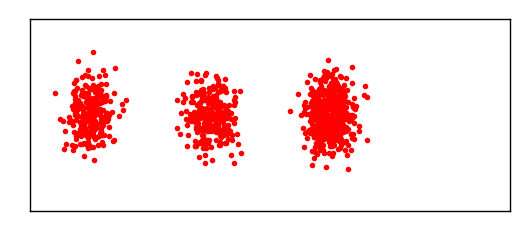

In [21]:
plot_imbalance_gaussian_dataset(t=100)

### forward direction

In [22]:
# data
XX_igd = imbalance_gaussian_dataset(0)[25:125]

# calculate K, MC, MC-fusion, and Ddim
track_mc_igd = TrackMC(K_max=10, criterion='NML', reg_covar=1e-3, random_state=0)
track_mc_igd.fit(XX_igd)
K_list_igd = track_mc_igd.K_list
mc_list_igd = track_mc_igd.mc_list(XX_igd)
mc_fusion_list_igd = track_mc_igd.mc_fusion_list(XX_igd)
ddim_list_igd = track_mc_igd.ddim_list(XX_igd)

# change point
change_K_igd = find_change(K_list_igd, 'K')
change_mc_igd = find_change(mc_list_igd, 'MC')
change_mc_fusion_igd = find_change(mc_fusion_list_igd, 'MC')
change_ddim_igd = find_change(np.log(ddim_list_igd), 'MC')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

#### Plotting and Calculation of AUC

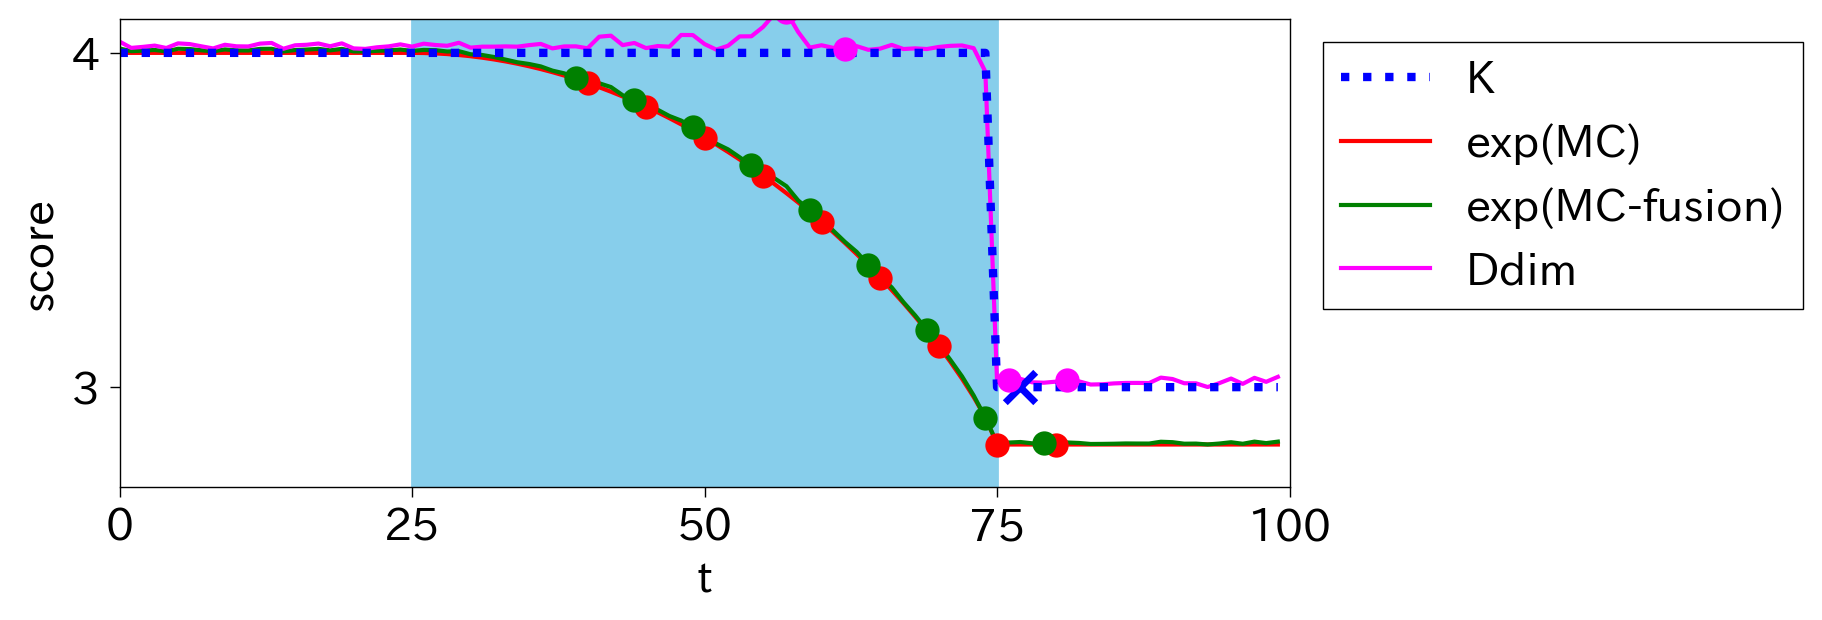

In [23]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 100)
ax.set_ylim(2.7, 4.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks([3, 4])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(25, 76), 2.7, 4.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(100), K_list_igd, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(100), np.exp(mc_list_igd), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), np.exp(mc_fusion_list_igd), color='green', label='exp(MC-fusion)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), ddim_list_igd, color='magenta', label='Ddim', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K_igd, np.array(K_list_igd)[change_K_igd], color='blue', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc_igd, np.exp(np.array(mc_list_igd))[change_mc_igd], color='red', s=60, marker='o')
ax.scatter(change_mc_fusion_igd, np.exp(np.array(mc_fusion_list_igd))[change_mc_fusion_igd], color='green',  s=60, marker='o')
ax.scatter(change_ddim_igd, np.array(ddim_list_igd)[change_ddim_igd], color='magenta',  s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.01, 1), 
    loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

#plt.savefig('imbalance_gaussian_0to100_1.pdf')
plt.show()

In [24]:
print(calc_auc_w5(mc_fusion_list_igd, 28, 82, up_or_down = 'down'))
print(calc_auc_w5(mc_list_igd, 28, 82, up_or_down = 'down'))
print(calc_auc_w5(ddim_list_igd, 28, 82, up_or_down = 'down'))
print(calc_auc_w5(K_list_igd, 28, 82, up_or_down = 'down'))

0.9281081081081082
1.0
0.7091891891891892
0.5


### reverse direction

In [25]:
# data
XX_igd_r = imbalance_gaussian_dataset(0)[25:125][::-1]

# calculate MC and K
track_mc_igd_r = TrackMC(K_max=10, criterion='NML', reg_covar=1e-3, random_state=0)
track_mc_igd_r.fit(XX_igd_r)
K_list_igd_r = track_mc_igd_r.K_list
mc_list_igd_r = track_mc_igd_r.mc_list(XX_igd_r)
mc_fusion_list_igd_r = track_mc_igd_r.mc_fusion_list(XX_igd_r)
ddim_list_igd_r = track_mc_igd_r.ddim_list(XX_igd_r)

# change point
change_K_igd_r = find_change(K_list_igd_r, 'K')
change_mc_igd_r = find_change(mc_list_igd_r, 'MC')
change_mc_fusion_igd_r = find_change(mc_fusion_list_igd_r, 'MC')
change_ddim_igd_r = find_change(np.log(ddim_list_igd_r), 'MC')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

#### Plotting and Calculation of AUC

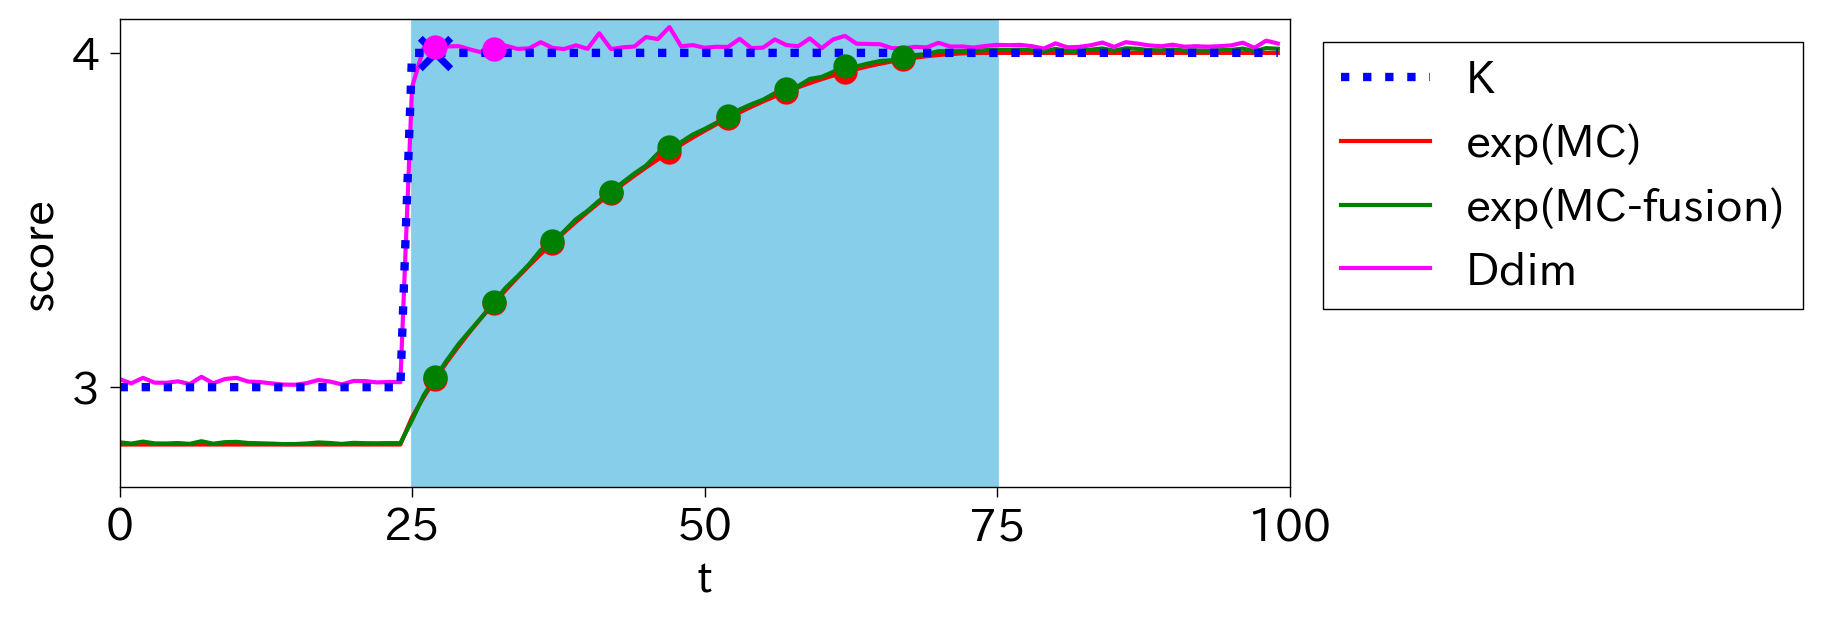

In [26]:
# plot setting
fig, ax = plt.subplots(figsize=(9, 3), dpi=200)
ax.set_xlim(0, 100)
ax.set_ylim(2.7, 4.1)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks([3, 4])
plt.subplots_adjust(top=0.98, right=0.71, bottom=0.20, left=0.06)

# transaction period
ax.fill_between(np.arange(25, 76), 2.7, 4.1, color='skyblue', zorder=-5)

# plot results
ax.plot(np.arange(100), K_list_igd_r, color='blue', label='K', linewidth=3.0, linestyle='dotted', zorder=0)
ax.plot(np.arange(100), np.exp(mc_list_igd_r), color='red', label='exp(MC)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), np.exp(mc_fusion_list_igd_r), color='green', label='exp(MC-fusion)', linewidth=1.5, linestyle='solid', zorder=-1)
ax.plot(np.arange(100), ddim_list_igd_r, color='magenta', label='Ddim', linewidth=1.5, linestyle='solid', zorder=-1)
ax.scatter(change_K_igd_r, np.array(K_list_igd_r)[change_K_igd_r], color='blue', s=120, marker='x', linewidth=2.5)
ax.scatter(change_mc_igd_r, np.exp(np.array(mc_list_igd_r))[change_mc_igd_r], color='red',  s=60, marker='o')
ax.scatter(change_mc_fusion_igd_r, np.exp(np.array(mc_fusion_list_igd_r))[change_mc_fusion_igd_r], color='green',  s=60, marker='o')
ax.scatter(change_ddim_igd_r, np.array(ddim_list_igd_r)[change_ddim_igd_r], color='magenta', s=60, marker='o')

# legend
ax.legend(
    bbox_to_anchor=(1.01, 1), 
    loc='upper left', fontsize=16, fancybox=False, edgecolor="black", framealpha=1
).get_frame().set_linewidth(0.5)

# title
ax.set_xlabel('t', fontsize=16)
ax.set_ylabel('score', fontsize=16)

#plt.savefig('imbalance_gaussian_100to0_1.pdf')
plt.show()

In [27]:
print(calc_auc_w5(mc_fusion_list_igd_r, 27, 81, up_or_down = 'up'))
print(calc_auc_w5(mc_list_igd_r, 27, 81, up_or_down = 'up'))
print(calc_auc_w5(ddim_list_igd_r, 27, 81, up_or_down = 'up'))
print(calc_auc_w5(K_list_igd_r, 27, 81, up_or_down = 'up'))

1.0
1.0
1.0
1.0


# Analysis of COVID-19 infection data

## Data preprocess

In [29]:
filename_cases = "../data/time_series_covid19_confirmed_global.csv"
cases_origin = pd.read_csv(filename_cases)

filename_deaths = "../data/time_series_covid19_deaths_global.csv"
deaths_origin = pd.read_csv(filename_deaths)

df_pop2019 = pd.read_csv('../data/population_2019.csv', index_col=0)

In [30]:
def preprocessing(country, cases_origin, deaths_origin):
    cases = deepcopy(cases_origin)
    deaths = deepcopy(deaths_origin)

    if country == 'Congo':
        cases = cases[(cases["Country/Region"] == 'Congo (Brazzaville)') | (cases["Country/Region"] == 'Congo (Kinshasa)')].iloc[:, 4:].sum().T
        deaths = deaths[(deaths["Country/Region"] == 'Congo (Brazzaville)') | (deaths["Country/Region"] == 'Congo (Kinshasa)')].iloc[:, 4:].sum().T

    elif country != "China" and country != "Canada" and country != 'Australia':
        # Cumulative Deaths
        deaths = deaths[(deaths["Country/Region"] == country) &
                        (deaths["Province/State"].isnull() == True)].T.iloc[4:]
        # Cumulative Cases
        cases = cases[(cases["Country/Region"] == country) &
                      (cases["Province/State"].isnull() == True)].T.iloc[4:]

    else:
        deaths = deaths[(deaths["Country/Region"] == country)
                        ].iloc[:, 4:].sum().T
        cases = cases[(cases["Country/Region"] == country)].iloc[:, 4:].sum().T


    deaths = deaths.reset_index()
    deaths.columns = ["date", "deaths"]
    deaths['date'] = pd.to_datetime(deaths['date'])

    cases = cases.reset_index()
    cases.columns = ["date", "cases"]
    cases["date"] = pd.to_datetime(cases["date"])
    
    cases = cases.sort_values("date", ascending=True).reset_index(drop=True)
    
    cases['recovered'] = cases['cases'].shift(14)
    cases = cases.fillna(0)
    
    cases['infected'] = cases['cases'] - cases['recovered']

    cases = pd.merge(cases, deaths, on="date", how="left")

    cases["day"] = cases["date"].dt.day
    cases["month"] = cases["date"].dt.month
    cases["year"] = cases["date"].dt.year

    if country == "Korea, South":
        ctr = "South_Korea"
    elif country == "US":
        ctr = "United_States_of_America"
    elif country == "Saudi Arabia":
        ctr = "Saudi_Arabia"
    elif country == "United Arab Emirates":
        ctr = "United_Arab_Emirates"
    elif country == "United Kingdom":
        ctr = "United_Kingdom"
    elif country == "Antigua and Barbuda":
        ctr = "Antigua_and_Barbuda"
    elif country == "Bosnia and Herzegovina":
        ctr = "Bosnia_and_Herzegovina"
    elif country == "Burkina Faso":
        ctr = "Burkina_Faso"
    elif country == "Central African Republic":
        ctr = "Central_African_Republic"
    elif country == "Costa Rica":
        ctr = "Costa_Rica"
    elif country == "Cote d'Ivoire":
        ctr = "Cote_dIvoire"
    elif country == "Dominican Republic":
        ctr = "Dominican_Republic"
    elif country == "El Salvador":
        ctr = "El_Salvador"
    elif country == "Equatorial Guinea":
        ctr = "Equatorial_Guinea"
    elif country == "Holy See":
        ctr = "Holy_See"
    elif country == "Marshall Islands":
        ctr = "Marshall_Islands"
    elif country == "New Zealand":
        ctr = "New_Zealand"
    elif country == "North Macedonia":
        ctr = "North_Macedonia"
    elif country == "Papua New Guinea":
        ctr = "Papua_New_Guinea"
    elif country == "Saint Kitts and Nevis":
        ctr = "Saint_Kitts_and_Nevis"
    elif country == "San Marino":
        ctr = "San_Marino"
    elif country == "Sao Tome and Principe":
        ctr = "Sao_Tome_and_Principe"
    elif country == "Sierra Leone":
        ctr = "Sierra_Leone"
    elif country == "Solomon Islands":
        ctr = "Solomon_Islands"
    elif country == "South Africa":
        ctr = "South_Africa"
    elif country == "South Sudan":
        ctr = "South_Sudan"
    elif country == "Sri Lanka":
        ctr = "Sri_Lanka"
    elif country == "Trinidad and Tobago":
        ctr = "Trinidad_and_Tobago"
    elif country == "Guinea-Bissau":
        ctr = "Guinea_Bissau"
    elif country == "Taiwan*":
        ctr = "Taiwan"
    elif country == "Timor-Leste":
        ctr = "Timor_Leste"
    elif country == "Saint Lucia":
        ctr = "Saint_Lucia"
    elif country == "Saint Vincent and the Grenadines":
        ctr = "Saint_Vincent_and_the_Grenadines"
    else:
        ctr = country

    cases["countriesAndTerritories"] = ctr
    cases["date"] = cases["date"].dt.strftime('%d/%m/%Y')
    cases = cases.rename(columns={'date': 'dateRep'})

    cases = cases.reindex(columns=['dateRep', 'cases', 'recovered', 'infected', 'deaths',
                                   'day', 'month', 'year', 'countriesAndTerritories'])
    
    
    cases['deaths_14'] = cases['deaths'].shift(14)
    cases = cases.fillna(0)
    cases['deaths_recent'] = cases['deaths'] - cases['deaths_14']

    cases['recovered'] = cases['recovered'] - cases['deaths_14']
    cases['infected'] = cases['infected'] - cases['deaths_recent']

    return cases

In [31]:
# All countries
countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
'Antigua and Barbuda', 'Argentina', 'Armenia', 
'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
'Bhutan', 'Bolivia',
'Bosnia and Herzegovina',
'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi',
'Cambodia', 'Cameroon', 'Canada',
'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
'Cuba', 'Cyprus', 'Czechia','Denmark', 'Djibouti',
'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 
'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
'Greece',  'Grenada',  'Guatemala', 
'Guinea', "Guinea-Bissau", 'Guyana', 'Haiti', 'Holy See',
'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica',
'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo',
'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho',
'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg',
'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta',
'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova',
'Monaco', 'Mongolia', 'Montenegro', 'Morocco',
'Mozambique', 'Namibia', 'Nepal', 'Netherlands',
'New Zealand', 'Nicaragua', 'Niger', 'Nigeria',
'North Macedonia', 'Norway', 'Oman',
'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay',
'Peru', 'Philippines', 'Poland', 'Portugal', 
'Qatar', 'Romania', 'Russia', 'Rwanda', 'Saint Kitts and Nevis',
'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino',
'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia',
'Seychelles', 'Sierra Leone', 'Singapore', 
'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia',
'South Africa', "Korea, South", 'South Sudan', 'Spain', 'Sri Lanka',
'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', "Taiwan*",
'Tajikistan', 'Thailand', "Timor-Leste", 'Togo',
'Trinidad and Tobago', 'Tunisia', 'Turkey',
'Uganda', 'Ukraine',
'United Arab Emirates', 'United Kingdom',
'US',
'Uruguay', 'Uzbekistan', 'Vanuatu',
'Venezuela', 'Vietnam', 
'Yemen', 'Zambia', 'Zimbabwe']

df = pd.DataFrame()

for country in tqdm(countries):
    ret = preprocessing(country, cases_origin=cases_origin, deaths_origin=deaths_origin)
    df = pd.concat([df, ret], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:57<00:00,  3.15it/s]


In [32]:
countries = df['countriesAndTerritories'].unique()

df = df.merge(df_pop2019, on='countriesAndTerritories', how='left')

df['I'] = df['infected'] / df['pop2019']
df['R'] = df['recovered'] / df['pop2019']
df['D'] = df['deaths'] / df['pop2019']

df["dateRep"] = pd.to_datetime(df["dateRep"], format="%d/%m/%Y")
date_list = df['dateRep'].sort_values().unique()

In [33]:
XX_sir = np.zeros([1000, 182, 3])
for j in tqdm(range(182)):
    country = countries[j]
    df_j = df[df['countriesAndTerritories'] == country]    
    
    for i in range(1000):
        date_i = date_list[i]
        df_i_j = df_j[df_j['dateRep'] == date_i]
        XX_sir[i,j,0] = df_i_j.iloc[0]['I']
        XX_sir[i,j,1] = df_i_j.iloc[0]['R']
        XX_sir[i,j,2] = df_i_j.iloc[0]['D']

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [03:02<00:00,  1.00s/it]


## Analysis

In [35]:
params = {
    'K_max': 10,
    'beta': 0.01,
    'random_state': 0,
    'num_em': 10,
    'R': 1e+3,
    'lmd_min': 1e-3,
    'reg_covar': 1e-9,
    'verbose': True,
}

# calculate K, MC, MC-fusion, and Ddim
track_mc_sir = TrackMC(**params, criterion='NML')
track_mc_sir.fit(XX_sir)
K_list_sir = track_mc_sir.K_list
mc_list_sir = track_mc_sir.mc_list(XX_sir)
mc_fusion_list_sir = track_mc_sir.mc_fusion_list(XX_sir)
ddim_list_sir = track_mc_sir.ddim_list(XX_sir)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\KentoUrano\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it 

### Plot

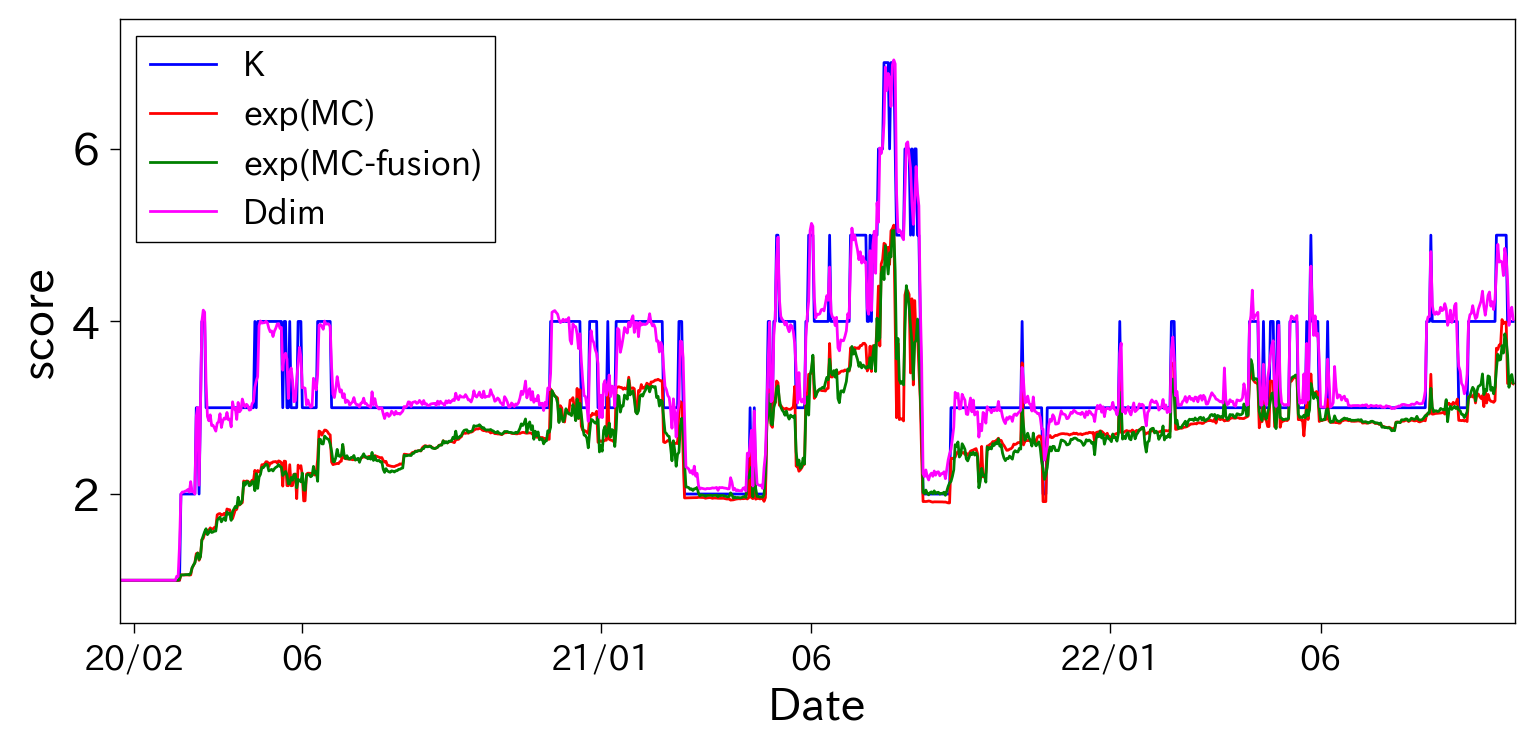

In [36]:
fig, ax = plt.subplots(figsize=(9.0, 4.0), dpi=200)

# plot setting
ax.set_xlim(0, 1000)
#####
ymax = 7.5
ymin = 0.5
#####
ax.set_ylim(ymin, ymax)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([10, 131, 345, 496, 710, 861])
ax.set_xticklabels(['20/02', '06', '21/01', '06', '22/01', '06'], fontsize=12)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('score', fontsize=16)
    
# plots
ax.plot(np.arange(1000), K_list_sir, color='blue', linewidth=1.0, linestyle='solid', label='K')
ax.plot(np.arange(1000), np.exp(mc_list_sir), color='red', linewidth=1.0, linestyle='solid', label='exp(MC)')
ax.plot(np.arange(1000), np.exp(mc_fusion_list_sir), color='green', linewidth=1.0, linestyle='solid', label='exp(MC-fusion)')
ax.plot(np.arange(1000), ddim_list_sir, color='magenta', linewidth=1.0, linestyle='solid', label='Ddim')

ax.legend(
    #bbox_to_anchor=(1.05, 1), 
    loc='upper left', fontsize=12, fancybox=False, edgecolor="black",
    framealpha=1
).get_frame().set_linewidth(0.5)

#plt.savefig('covid_result_all.pdf')

plt.show()

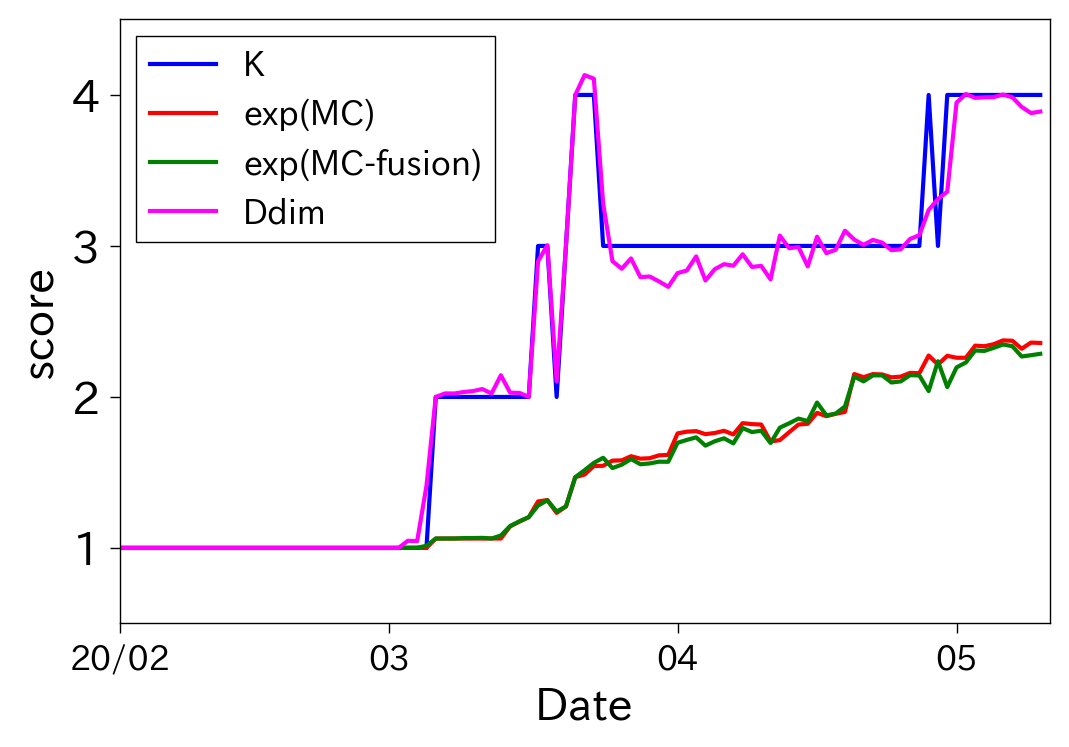

In [37]:
fig, ax = plt.subplots(figsize=(6.0, 4.0), dpi=200)

ts = 10
tf = 110

# plot setting
ax.set_xlim(ts, tf)
#####
ymax = 4.5
ymin = 0.5
#####
ax.set_ylim(ymin, ymax)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([10, 39, 70, 100])
ax.set_xticklabels(['20/02', '03', '04', '05'], fontsize=12)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('score', fontsize=16)
    
# plots
ax.plot(np.arange(ts, tf), K_list_sir[ts : tf], color='blue', linewidth=1.5, linestyle='solid', label='K')
ax.plot(np.arange(ts, tf), np.exp(mc_list_sir[ts : tf]), color='red', linewidth=1.5, linestyle='solid', label='exp(MC)')
ax.plot(np.arange(ts, tf), np.exp(mc_fusion_list_sir[ts : tf]), color='green', linewidth=1.5, linestyle='solid', label='exp(MC-fusion)')
ax.plot(np.arange(ts, tf), ddim_list_sir[ts : tf], color='magenta', linewidth=1.5, linestyle='solid', label='Ddim')

ax.legend(
    #bbox_to_anchor=(1.05, 1), 
    loc='upper left', fontsize=12, fancybox=False, edgecolor="black",
    framealpha=1
).get_frame().set_linewidth(0.5)

#plt.savefig('covid_result_syoki.pdf')

plt.show()

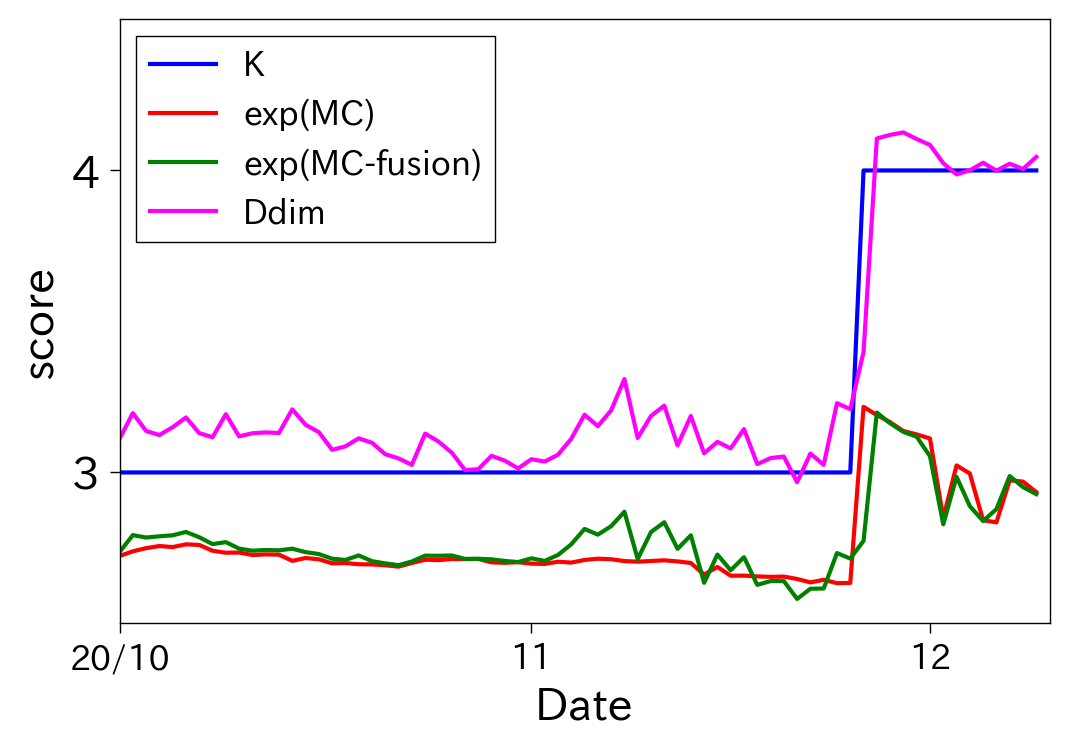

In [38]:
fig, ax = plt.subplots(figsize=(6.0, 4.0), dpi=200)

ts = 253
tf = 323

# plot setting
ax.set_xlim(ts, tf)
#####
ymax = 4.5
ymin = 2.5
#####
ax.set_ylim(ymin, ymax)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_yticks([3, 4])
ax.set_xticks([253, 284, 314])
ax.set_xticklabels(['20/10', '11', '12'], fontsize=12)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('score', fontsize=16)
    
# plots
ax.plot(np.arange(ts, tf), K_list_sir[ts : tf], color='blue', linewidth=1.5, linestyle='solid', label='K')
ax.plot(np.arange(ts, tf), np.exp(mc_list_sir[ts : tf]), color='red', linewidth=1.5, linestyle='solid', label='exp(MC)')
ax.plot(np.arange(ts, tf), np.exp(mc_fusion_list_sir[ts : tf]), color='green', linewidth=1.5, linestyle='solid', label='exp(MC-fusion)')
ax.plot(np.arange(ts, tf), ddim_list_sir[ts : tf], color='magenta', linewidth=1.5, linestyle='solid', label='Ddim')

ax.legend(
    #bbox_to_anchor=(1.05, 1), 
    loc='upper left', fontsize=12, fancybox=False, edgecolor="black",
    framealpha=1
).get_frame().set_linewidth(0.5)

#plt.savefig('covid_result_chuban.pdf')

plt.show()

### Visualization

2020-12-01T00:00:00.000000000
[[7.03548097e-03 1.91312203e-02 6.78053120e-04]
 [5.38831909e-05 6.37095021e-04 1.36688054e-05]
 [4.00805682e-03 2.89431558e-02 6.07466055e-04]
 [1.31062088e-03 7.85814388e-03 1.49948623e-04]]


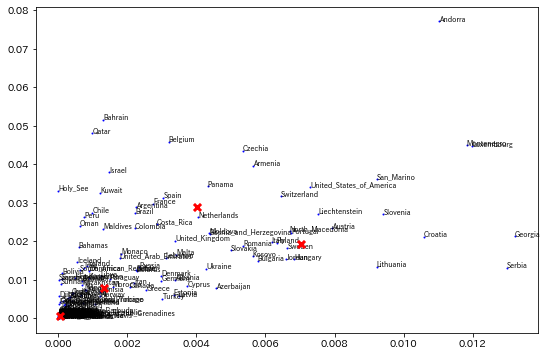

In [39]:
t = 314
print(date_list[t])

gmm = track_mc_sir.gmm_list_[t]
X = XX_sir[t]
Z = gmm.model.predict(X)

plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=1, c='blue')
for i, country in enumerate(countries):
    plt.text(X[i, 0], X[i, 1],country, size=7)

means = gmm.model.means_
print(means)
for k in range(gmm.K):
    plt.scatter(means[k, 0], means[k, 1], color='r', marker='x', linewidths=3, s=50, zorder=3)

# Analysis of Electric Power Consumption Data

In [40]:
with open('../data/XX_house.pkl', 'rb') as f:
    XX_house = pkl.load(f)

In [41]:
XX_house.shape

(96, 4326, 3)

In [42]:
params = {
    'K_max': 20,
    'beta': 0.01,
    'random_state': 0,
    'num_em': 10,
    'R': 1e+3,
    'lmd_min': 1e-3,
    'reg_covar': 0.1,
    'verbose': True,
}

# calculate K, MC, MC-fusion, and Ddim
track_mc_house = TrackMC(**params, criterion='NML')
track_mc_house.fit(XX_house)
K_list_house = track_mc_house.K_list
mc_list_house = track_mc_house.mc_list(XX_house)
mc_fusion_list_house = track_mc_house.mc_fusion_list(XX_house)
ddim_list_house = track_mc_house.ddim_list(XX_house)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [07:09<00:00,  4.48s/it]


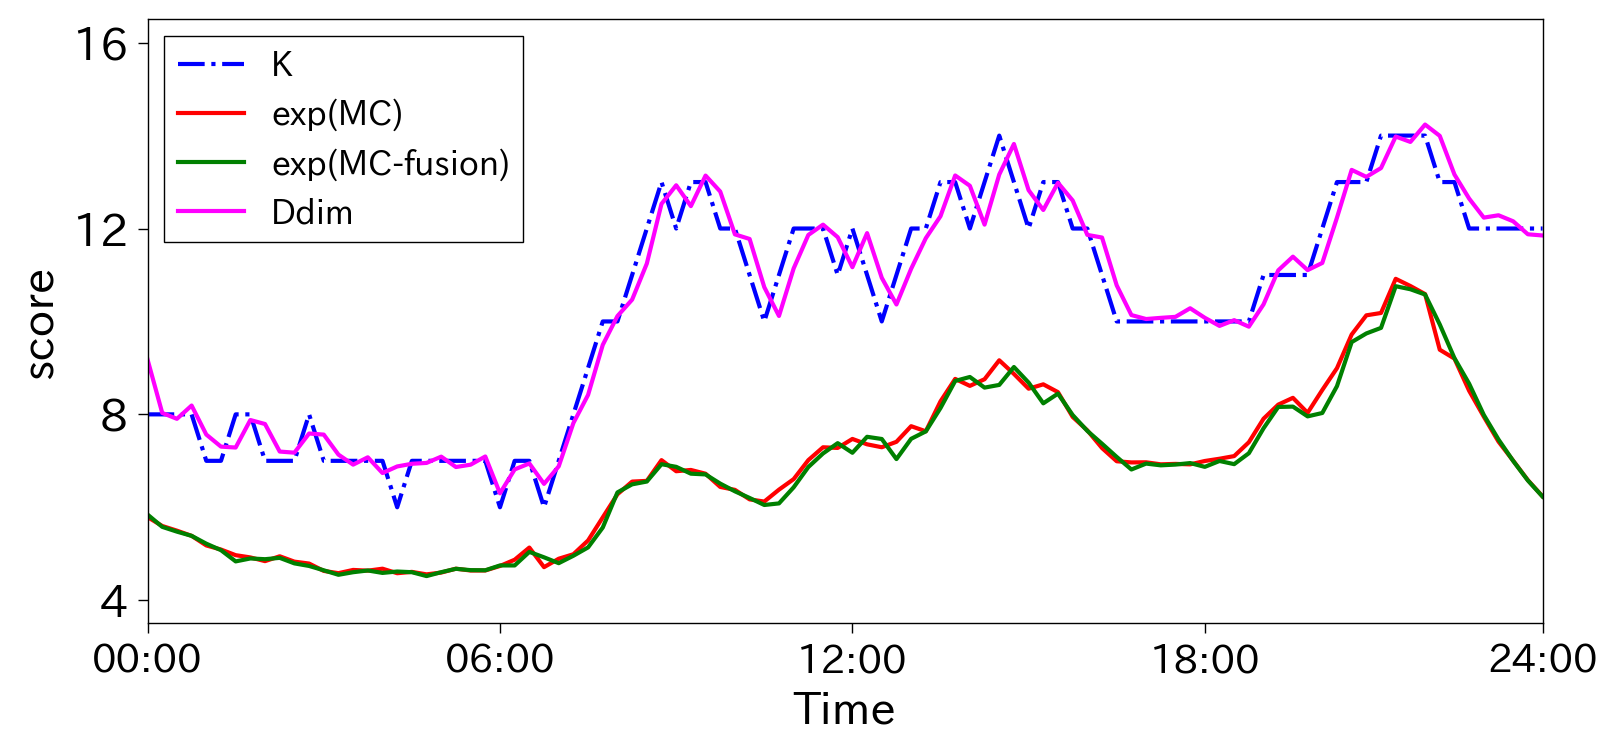

In [43]:
fig, ax = plt.subplots(figsize=(9.0, 4.0), dpi=200)

# plot setting
ax.set_xlim(0, 78)
#####
ymax = 16.5
ymin = 3.5
#####
ax.set_ylim(ymin, ymax)
for a in ['top', 'right', 'bottom', 'left']:
    ax.spines[a].set_linewidth(0.5)
ax.tick_params(labelsize=16, width=0.5)
ax.set_xticks([0, 24, 48, 72, 95])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'], fontsize=14)
ax.set_yticks([4, 8, 12, 16])
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('score', fontsize=16)
    
# plots
ax.plot(np.arange(96), K_list_house, color='blue', linewidth=1.5, linestyle='dashdot', label='K')
ax.plot(np.arange(96), np.exp(mc_list_house), color='red', linewidth=1.5, linestyle='solid', label='exp(MC)')
ax.plot(np.arange(96), np.exp(mc_fusion_list_house), color='green', linewidth=1.5, linestyle='solid', label='exp(MC-fusion)')
ax.plot(np.arange(96), ddim_list_house, color='magenta', linewidth=1.5, linestyle='solid', label='Ddim')

ax.legend(
    #bbox_to_anchor=(1.01, 1), 
    loc='upper left', fontsize=12, fancybox=False, edgecolor="black",
    framealpha=1
).get_frame().set_linewidth(0.5)

#plt.savefig('house_result.pdf')

plt.show()